<h2 align=center> <b><u> Fine-Tuned BERT for Sentiment Analysis on the Sentiment140 Dataset </u></b>
</h2>

### 1. Check GPU Availability and install dependencies

In [1]:
!nvidia-smi

Wed Apr  3 16:38:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# !pip install tensorflow_text
import tensorflow_text as text  # Registers the ops.


# After running this cell, we have to restart the Kernel and after restarting run this cell once again!

2024-04-03 16:38:47.987653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 16:38:47.987775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 16:38:48.151653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2. Import the Quora Insincere Questions Dataset

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras_nlp

In [4]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",
                 names = col_names,
                 encoding = "ISO-8859-1")
df.shape

(1600000, 6)

In [6]:
df.tail()

,target,id,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


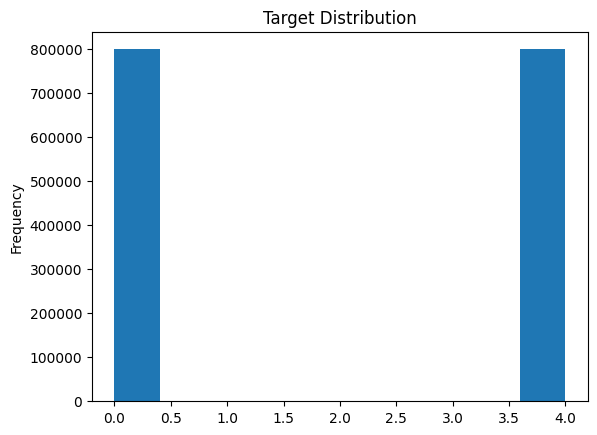

In [7]:
df.target.plot(kind='hist', title = 'Target Distribution');

In [8]:
# renaming the labels as 0 and 1 instead of 0 and 4

df.replace({'target':{4:1}}, inplace = True)

### 0 --> Negative Tweet, 1 --> Positive Tweet

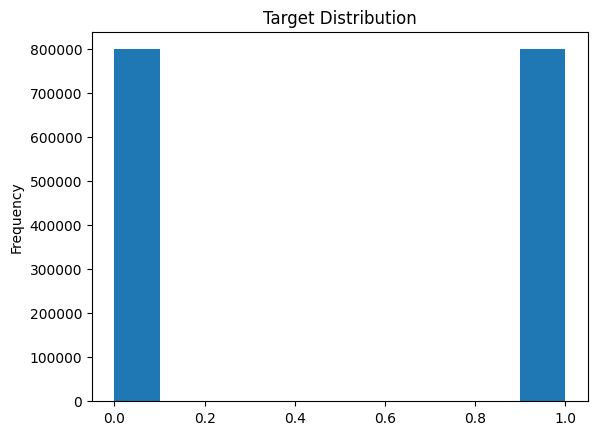

In [9]:
df.target.plot(kind='hist', title = 'Target Distribution');

### 3. Preparing Input Data for Training and Evaluation

Since BERT is a pretrained model, it is sufficient to train it on a small subset of the original dataset. Else, training the entire dataset on BERT would take nearly 7 hours to complete!!! 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Splitting the dataset into train and valid (90% and 10% respectively)
train_df, test_df = train_test_split(df, random_state=42, train_size=0.1, test_size = 0.01, stratify=df.target.values)

In [11]:
X_train = train_df["text"]
y_train = train_df["target"]

X_test = test_df["text"]
y_test = test_df["target"]

In [12]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(160000,)
(160000,)
(16000,)
(16000,)


### 4. Input Format for BERT

**Token IDs** - This corresponds to the tokenized strings padded with 0s
                upto the max sequence length and beginning with CLS and ending with SEP. <br><br>
**Input Mask** - Note that BERT uses Self-Attention Networks to provide
                 contextualised embeddings corresponding to each token in the token string i.e., for each word in the string BERT looks to the left and right of it in the sentence so as to find contextual meaning of the word in the sentence (say, if there is a "the", then look at the noun to which it points). Now, note that we have padded our token strings with 0s upto the max seq length, but we do not want the padding 0s to influence the contextual information to be derived.  The Input Mask is a list of same length as the length of Token Ids (ie the max seq length) where there is a 0 for a padding and 1 for a valid token. The 0s will cancel out the internal multiplications that we perform for capturing the Self Attention for contextual information. <br><br>

**Input Type IDs** - Note that originally BERT was pretrained on two   tasks, Masked Language Modelling (where random words from the sentence would be masked and it would be the task for the BERT to predict what those masked words are) and the other task was Next Sentence Prediction or NSP (Given two sentences, the BERT has to predict which came first and which came after. The first sentence was given the value 0 and the next sentence was given the value 1).<br><br>
**In Text classification, we are dealing with only 1 sequence at a time, so our input type IDs would just be a vector with all values 0. **


### 5. Checking the tokenization process

In [13]:
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

# Tokenize the input text
input_text = ["Hello, how are you?"]
tokenized_output = preprocessor(input_text)

# Print token IDs
print(tokenized_output['input_word_ids'])
print(tokenized_output['input_mask'])
print(tokenized_output['input_type_ids'])

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...


tf.Tensor(
[[ 101 7592 1010 2129 2024 2017 1029  102    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 128), dty

Upon checking the input word ids, we find that the tokens are --> "Hello", "#,", "how", "are", "you" and "#?" {'#' signifies that the succeeding character ',' is attached to characters before] and they are encoded as [7592 1010 2129 2024 2017 1029]. 

Note that this is not the whole story. We also have to make sure that each sequence is initiated with the CLS token (which signifies start of sequence and has a token_id 101) and ended with SEP (separator) which means end of sequence and has a token_id 102. Also we have to make sure that all tensors have sequence size equal to the max_sequence_length by using padding.

### 6. Add a Classification Head to the BERT Layer

We only need the pooled_output that represents the whole sentence (using the CLS token that contains the contextual information of the whole sentence) and not the sequence_output.

In [14]:
# Building the model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en_uncased",trainable=True)
encoder_inputs = preprocessor(text_input)
encoder = keras_nlp.models.BertBackbone.from_preset("bert_base_en_uncased")
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].




# Classification
# Add dropout layer
drop1 = tf.keras.layers.Dropout(0.2)(pooled_output)

# Add hidden dense layers
hidden1 = tf.keras.layers.Dense(128, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(0.2)(hidden2)

# Output layer
output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop3)


model=tf.keras.Model(inputs=[text_input],outputs=[output_layer])

Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...


### 7. Fine-Tune BERT for Text Classification

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.F1Score()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_preprocessor   │ [(None, 512),     │          0 │ input_layer[0][0] │
│ (BertPreprocessor)  │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 768),     │ 109,482,2… │ bert_preprocesso… │
│ (BertBackbone)      │ (None, 512, 768)] │            │ bert_preprocesso… │
│                     │                   │            │ bert_preprocesso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 768)       │          0 │ bert_backbone[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     98,432 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      4,128 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 32)        │          0 │ dense_1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,584,833 (418.03 MB)

 Trainable params: 109,584,833 (418.03 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/best_model.keras',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_binary_accuracy',  # Quantity to be monitored  # Do not save the entire model
        verbose=1,  # Verbosity mode. 0 or 1.
        save_freq='epoch'  # Save the model at the end of every epoch
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        monitor='val_binary_accuracy',  # Quantity to be monitored
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_binary_accuracy',  # Quantity to be monitored
        factor=0.5,  # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-7  # Lower bound on the learning rate
    )
]

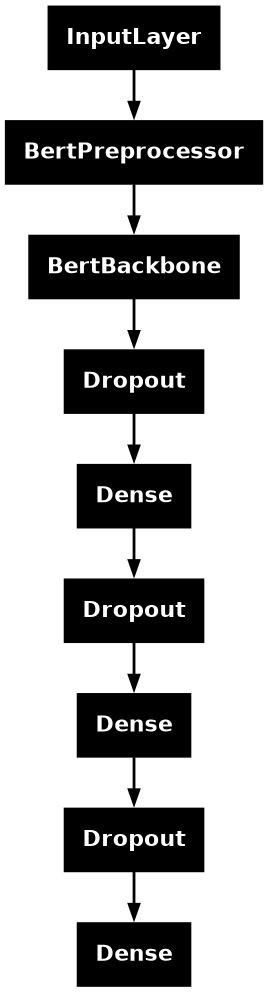

In [17]:
# Plot the model architecture
tf.keras.utils.plot_model(model, dpi=100)

In [18]:
# Train model
epochs = 2
history = model.fit(X_train, 
                    y_train,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks
                   )

Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_51198[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, _output_shapes=[[32,1]], _user_specified_name="data", index=0){{node data}}
The op is created at: 
File "opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
File "opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
File "opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start
File "opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
File "opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
File "opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute
File "opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell
File "opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "tmp/ipykernel_26/4210623540.py", line 3, in <module>
File "opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator
File "opt/conda/lib/python3.10/site-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments
File "opt/conda/lib/python3.10/site-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value
File "opt/conda/lib/python3.10/site-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>
	tf2xla conversion failed while converting __inference_one_step_on_data_51198[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_52531]

### 8. Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    #plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    #plt.legend([metric, 'val_'+metric])
    plt.legend([metric])
    plt.show()

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
plot_graphs(history, 'binary_accuracy')

### 9. Sanity Checking

In [ ]:
sample_example = ["why are americans racist?", "why are indians so black?", "have a great day!"]
preds = model.predict(sample_example)
threshold = 0.5 #between 0 and 1


["Positive Tweet" if pred>=threshold else "Negative Tweet" for pred in preds]

### 10. Trying the Trained BERT Model on Test Data

In [ ]:
print(X_test.shape)
print(y_test.shape)

In [ ]:
y_predict=model.predict(X_test)

In [ ]:
y_predict.shape

In [ ]:
threshold = 0.5
preds = [1 if pred[0]>=threshold else 0 for pred in y_predict]

### 11. Performance on Test Data

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, preds)

print("Binary Accuracy on Test Data:", round(accuracy*100, 3))